# (INFO-F422) Statistical foundations of machine learning: Project 24-25

description: regression task, predict continuous hand proshtesis movement through short time-windows hand pose (angles) from forearm electrode sensors. 

+ author 1
+ author 2
+ author 3

___

## Imports

In [20]:
# models
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# model selection
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.decomposition import PCA

# preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum

___

## Data loading

In [5]:
data_dir = "data"

X_g_train = np.load(f"{data_dir}/guided/guided_dataset_X.npy")
y_g_train = np.load(f"{data_dir}/guided/guided_dataset_y.npy")
X_g_test = np.load(f"{data_dir}/guided/guided_testset_X.npy")

X_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_X.npy")
y_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_y.npy")
X_f_test = np.load(f"{data_dir}/freemoves/freemoves_testset_X.npy")


In [6]:
print("Guided:")
print(f"X_g_train {X_g_train.shape} / y_g_train{y_g_train.shape} / X_g_test{X_g_test.shape}\n")
print("Free moves:")
print(f"X_f_train{X_f_train.shape} / y_f_train{y_f_train.shape} / X_f_test{X_f_test.shape}")

Guided:
X_g_train (5, 8, 230000) / y_g_train(5, 51, 230000) / X_g_test(5, 332, 8, 500)

Free moves:
X_f_train(5, 8, 270000) / y_f_train(5, 51, 270000) / X_f_test(5, 308, 8, 500)


___

## Data preparation

In [7]:
class XWindowAugment(BaseEstimator, TransformerMixin):
    """
    Augment X through overlapping windows
    """
    
    def __init__(self, window_size=500, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        X_windows = np.lib.stride_tricks.sliding_window_view(X,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        X_windows = X_windows[:,:,::step,:]
         
        # (session, electrode, window, time) to (session, window, electrode, time)
        X_windows = X_windows.transpose(0, 2, 1, 3) 
        
        return X_windows   

In [8]:
class yWindowAugment(BaseEstimator, TransformerMixin):
    """
    + Augment y through overlapping windows 
    + Extract target of correspondoing windows
    """
    
    def __init__(self, window_size=500, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
    
    def fit(self, y, X=None):
        return self
    
    def transform(self, y, X=None):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # ----- window augment -----
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        y_windows = np.lib.stride_tricks.sliding_window_view(y,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        y_windows = y_windows[:,:,::step,:]
         
        # (session, angles, window, time) to (session, window, angles, time)
        y_windows = y_windows.transpose(0, 2, 1, 3)     
        
        # ----- target extract -----
        
        y_windows = y_windows[:, :, :, -1] # keep last hand pose as window target
        
        return y_windows

Prepared data

In [9]:
X_g_train_wdw = XWindowAugment().transform(X_g_train)
y_g_train_wdw = yWindowAugment().transform(y_g_train)

print("Guided windowed:")
print(f"X_g_train_wdw {X_g_train_wdw.shape} / X_g_test {X_g_test.shape}")
print(f"y_g_train_wdw{y_g_train_wdw.shape}")

Guided windowed:
X_g_train_wdw (5, 919, 8, 500) / X_g_test (5, 332, 8, 500)
y_g_train_wdw(5, 919, 51)


___

## Cross validation strategy

strategy: session based Leave One Group Out

+ no **window overlap leakage**
+ avoids **session bias**: signal drift, sensors placements, ... 

In [10]:
n_sessions, n_windows, n_electrodes, n_times = X_g_train_wdw.shape
groups = np.repeat(np.arange(1,n_sessions+1), n_windows) # [1 ... 1], [2 ... 2], ..., [5 ...5] each group of lenght n_windows

# loss functions
def mse(y_true, y_hat):
    return np.mean((y_true-y_hat)**2)
def rmse(y_true, y_hat):
    return np.sqrt(np.mean((y_true-y_hat)**2))
def nmse(y_true, y_hat):
    return np.mean((y_true-y_hat)**2)/np.std(y_true)**2

# scorers
rmse_scorer = make_scorer(rmse, greater_is_better=False)
nmse_scorer = make_scorer(nmse, greater_is_better=False)

# cv function 
logo = LeaveOneGroupOut()
def logo_cv(X, y, model, scorer=rmse_scorer):
    cv_scores = cross_val_score(model, X, y, groups=groups, cv=logo, scoring=scorer, n_jobs=-1)
    return np.mean(-cv_scores)

def _logo_cv(X, y, model):
    cv_nmse = []
    cv_rmse = []
    for train_index, test_index in logo.split(X, y, groups):
        X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_ts = y[train_index], y[test_index]
        
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_ts)
        cv_nmse.append(nmse(y_ts, y_hat))
        cv_rmse.append(rmse(y_ts, y_hat))
        
    return (np.mean(cv_rmse), np.mean(cv_nmse))

___

## Common time features extraction

TODO: why ?

+ Mean Absolute Value (MAV)
+ Root Mean Square (RMS)
+ Variance (VAR)
+ Standard Deviation (STD)
+ Zero Crossing (ZC)
+ Myopulse Percentage Rate (MPR)

In [11]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Extracts common time-domain features, from numpy arrays into a dataframe (readability)
    """

    def __init__(self, mpr_threshold=0.5):
        self.mpr_threshold = mpr_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):        
        # --- Feature extraction ---
        feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR']
        n_features = len(feature_names)
        
        n_sessions, n_windows, n_electrodes, n_times = X.shape
        features = np.zeros((n_sessions * n_windows, n_electrodes * n_features))
        
        for s in range(n_sessions):
            for w in range(n_windows):
                i = s*n_windows + w # index in flattened contiguous windows samples 'form'
                wdw_features = []
                for e in range(n_electrodes):
                    signal = X[s, w, e, :] # window signal
                    
                    mav = np.mean(np.abs(signal))
                    rms = np.sqrt(np.mean(signal**2))
                    var = np.var(signal)
                    std = np.std(signal)
                    zc = np.sum(np.diff(np.signbit(signal)).astype(int))
                    mpr = np.mean(np.abs(signal) > self.mpr_threshold)    
                    wdw_features.extend([mav, rms, var, std, zc, mpr])
                
                features[i, :] = wdw_features
        
        # --- to Dataframe ---            
        column_names = [f"elec{e}_{name}" for e in range(n_electrodes) for name in feature_names]
        df = pd.DataFrame(features, columns=column_names)
        
        return df

In [12]:
class TargetFlattener(BaseEstimator, TransformerMixin):
    """
    Flatten feature set for sklearn usability
    """

    def fit(self, y, X=None):
        return self

    def transform(self, y, X=None):      
        
        # -- Reshape --
        n_sessions, n_windows, n_angles = y.shape
        
        # Reshape to (sessions*windows, angles)
        y_flat = y.reshape(n_sessions * n_windows, n_angles)
        
        # n_vals = 3 # 3 'values' per joint angle
        # column_names = [f"angle{i}_{k}" for i in range(0, n_angles, n_vals) for k in range(n_vals)]
        
        # df = pd.DataFrame(y_flat, columns=column_names)
        
        return y_flat

Preprocessed data 

In [13]:
X_g_train_preproc = FeatureExtractor().transform(X_g_train_wdw)
y_g_train_preproc = TargetFlattener().transform(y_g_train_wdw)

print("Guided preprocessed:")
print(f"X_g_train_preproc {X_g_train_preproc.shape}")
print(f"y_g_train_preproc{y_g_train_preproc.shape}")


Guided preprocessed:
X_g_train_preproc (4595, 48)
y_g_train_preproc(4595, 51)


___

## Baselines

1) Baseline exploration

2) analyse feature importance

3) final baseline model selection

#### 1) Baseline 'exploration'

+ try multiple baselines (different model families) to get a sense of data/model interaction, early signals of what models (assumptions) seems to work well on data
+ establishes a (cv) benchmark that more complex models should beat.

(default parametres - just get a sense of data/model interacton)

__note__: no leakage from feature extraction being outside cross validation loop, since feature extraction operates at window level (window infromation only), so no information leaked.

In [51]:
cv_results_baselines = {}
from sklearn.dummy import DummyRegressor
baselines = {
    'dummy_mean': DummyRegressor(strategy='mean'),
    "OLS": LinearRegression(n_jobs=-1),
    'random_forest': RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=10),
}

for name, model in baselines.items():
    cv_rmse, cv_nmse = _logo_cv(X_g_train_preproc, y_g_train_preproc, model)
    cv_results_baselines[name] = {"RMSE": cv_rmse, "NMSE": cv_nmse}

baselines_cv_df = pd.DataFrame(cv_results_baselines).T
baselines_cv_df

,RMSE,NMSE
dummy_mean,14.259043,0.437812
OLS,7.248052,0.113622
random_forest,5.094033,0.056900


In [52]:
# wont work with dummy mean anymore
del baselines['dummy_mean']

#### 2) Feature importance

informative and will serve for feature selection

+ __OLS__

```python
coef_ = [w_1_1, w_1_2, ..., w_1_48],  # weights of model 1
        ...
        [w_51_1, ..., w_51_48]        # weights of model 51
```
For interpretability and general insight we aggregate the feature importances across all outputs by taking the mean (abs to avoid negative weights to cancel out).

(inspired by [source](https://sourcebae.com/blog/how-to-get-coefficients-and-feature-importances-from-multioutputregressor/) and Tp5)

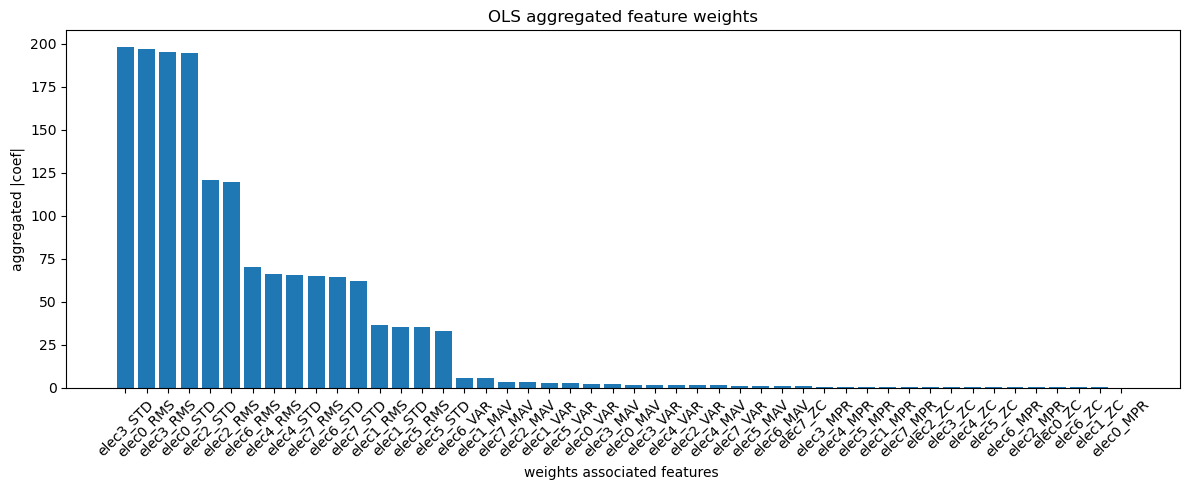

In [15]:
# OLS
ols_reg = LinearRegression(n_jobs=-1)
ols_reg_pipe = make_pipeline(StandardScaler(), ols_reg)
ols_reg_pipe.fit(X_g_train_preproc, y_g_train_preproc)

aggr_coef = np.mean(np.abs(ols_reg.coef_), axis=0) # average on columns
ols_sorted_idx = np.argsort(aggr_coef)[::-1] # descending order
column_names = X_g_train_preproc.columns

plt.figure(figsize=(12, 5))
plt.bar(range(len(aggr_coef)), aggr_coef[ols_sorted_idx], align='center')
plt.xticks(range(len(aggr_coef)), column_names[ols_sorted_idx], rotation=45)
plt.xlabel("weights associated features ")
plt.ylabel("aggregated |coef|")
plt.title("OLS aggregated feature weights")
plt.tight_layout()
plt.show()

+ __Random forest__

TODO: explanations [src](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html?utm_source=chatgpt.com)


<!-- 
Native multi‑output trees in scikit‑learn (e.g. DecisionTreeRegressor, RandomForestRegressor) treat the target Y as an (n samples,n outputs) array and, at each split, compute the impurity decrease as the sum of variances (for regression) across all outputs.

During fitting, each tree accumulates, for every feature, how much splitting on that feature reduces the total (sum‑of‑variance) impurity across all outputs

feature_importances_ is then the average, over all trees, of those total impurity‑reduction scores—one single importance per input feature that reflects its contribution jointly to all outputs.

Interpretation: A higher importance means “this feature, when used in splits, reduced the overall error summed over all 51 targets more than other features.
 -->

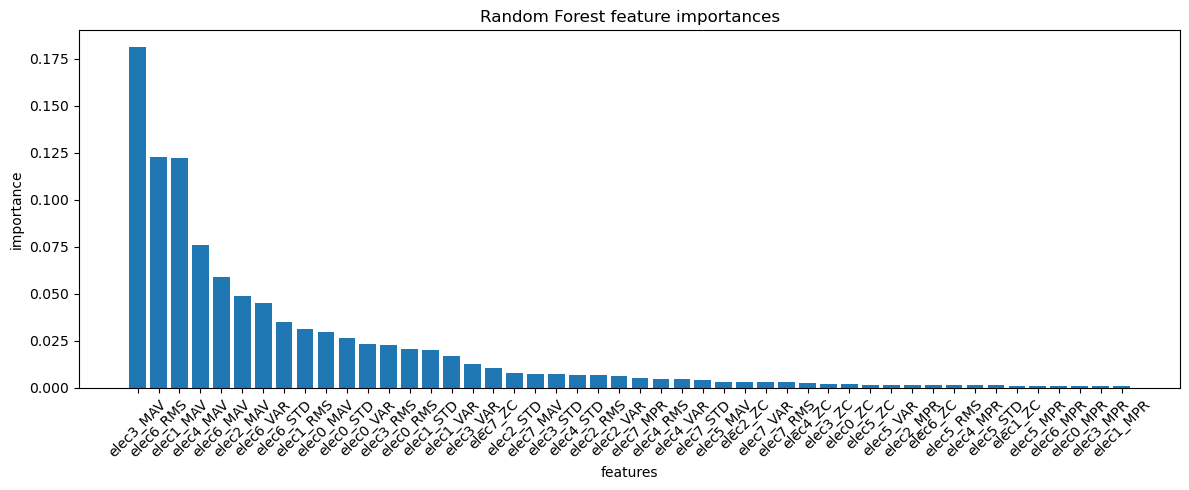

In [16]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)
rf.fit(X_g_train_preproc, y_g_train_preproc)
rf_feat_imp = rf.feature_importances_
rf_sorted_idx = np.argsort(rf_feat_imp)[::-1] # descending order

column_names = X_g_train_preproc.columns

plt.figure(figsize=(12, 5))
plt.bar(range(len(rf_feat_imp)), rf_feat_imp[rf_sorted_idx], align='center')
plt.xticks(range(len(rf_feat_imp)), column_names[rf_sorted_idx], rotation=45)
plt.xlabel("features")
plt.ylabel("importance")
plt.title("Random Forest feature importances")
plt.tight_layout()
plt.show()

#### 3) Feature selection

We experiment feature selection on baseline models with 2 different feature selection strategies () through a cross validated pipeline to avoid **data leakage** and thus optimistic results.

- If done separately, feature selection has peeked / used validation set information to perfrom the selection, the model is then trained on data that was modified having validation set informations !

**note**: We dont do hyper parametre tuning yet (in the same time), the goal is to find the best (model + feature selection strategy) combination as a baseline. We will do light tuning on the final best baseline pipeline to have a less trivial benchmark. Even if hyperparametres logically can interact with feature selection, it is a trade off we accept (for simplicity), if we had to handle it, it would be done with nested cv to again avoid leakage. **TODO**: explain why leakage avoided

__PCA__

In [53]:
"""
cv_results = 
    [
        [fold1_1c, fold2_1c, ... fold5_1c],
        [fold1_2c, fold2_2c, ... fold5_2c],
        ...
        [fold1_48c, fold2_48c, ... fold5_48c],
    ]
"""

n_features = X_g_train_preproc.shape[1]

def pca_loop_feat_selec(model):
    CV_err = np.zeros((n_features,n_sessions)) # (48, 5)
    for fold, (train_index, test_index) in enumerate(logo.split(X_g_train_preproc, y_g_train_preproc, groups=groups)):
        X_tr, X_ts = X_g_train_preproc.iloc[train_index], X_g_train_preproc.iloc[test_index]
        y_tr, y_ts = y_g_train_preproc[train_index], y_g_train_preproc[test_index]
        
        # fold independant PCA - no leaking
        pca = PCA(random_state=0)
        X_tr_pca = pca.fit_transform(X_tr)
        X_ts_pca = pca.transform(X_ts) # !! transform with fitted params on X_tr !!
        for k in range(n_features):
            model.fit(X_tr_pca[:, :k+1], y_tr) # train on k-best components
            y_hat = model.predict(X_ts_pca[:, :k+1])
            CV_err[k, fold] = rmse(y_hat, y_ts)

    best_n_components = 0
    best_cv_rmse = 100
    for k in range(n_features):
        cv_rmse = np.mean(CV_err[k])
        if cv_rmse < best_cv_rmse:
            best_n_components = k
            best_cv_rmse = cv_rmse
    
    return best_n_components, best_cv_rmse

def pca_grid_feat_selec(model, scorer=rmse_scorer):
    pipe = make_pipeline(
        PCA(),
        model
    )

    param_grid = {'pca__n_components': [i for i in range(1, n_features+1)]}

    grid = GridSearchCV(pipe, param_grid, cv=logo, scoring=scorer, n_jobs=-1)
    grid.fit(X_g_train_preproc, y_g_train_preproc, groups=groups)

    best_n_components = grid.best_params_['pca__n_components']
    best_cv_rmse = -grid.best_score_
    
    return best_n_components, best_cv_rmse

In [19]:
for name, model in baselines.items():
    best_n_components, best_cv_rmse = pca_grid_feat_selec(model)
    # best_n_components, best_cv_rmse = pca_loop_feat_selec(model)

    print(f"[{name}] Optimal #components = {best_n_components} with cv rmse = {best_cv_rmse}")

[dummy_mean] Optimal #components = 1 with cv rmse = 14.259043408011632
[OLS] Optimal #components = 48 with cv rmse = 7.248052301242538
[random_forest] Optimal #components = 26 with cv rmse = 5.450713485816227


__Embedded__

In [65]:
def embeded_grid_feat_selec(model, scorer=rmse_scorer):
    pipe = Pipeline([
        # use same model for predict and importances (both have coefs_ or feature_importances_ so it works)
        # set threshold to 0, set to mean by default (we want 'pure' feature selection).
        ('select', SelectFromModel(model, threshold=0)),
        ('model', model)
    ])

    # param_grid = {'selectfrommodel__max_features': [i for i in range(1, n_features+1)]}
    param_grid = {'select__max_features': [i for i in range(1, n_features+1)]}

    grid = GridSearchCV(pipe, param_grid, cv=logo, scoring=scorer, n_jobs=-1)
    grid.fit(X_g_train_preproc, y_g_train_preproc, groups=groups)

    best_n_features = grid.best_params_['select__max_features']
    best_cv_rmse = -grid.best_score_
    
    return best_n_features, best_cv_rmse

In [66]:
for name, model in baselines.items():
    best_n_features, best_cv_rmse = embeded_grid_feat_selec(model)
    
    print(f"[{name}] Optimal #features = {best_n_features} with cv rmse = {best_cv_rmse}")

[OLS] Optimal #features = 48 with cv rmse = 7.248052301254961
[random_forest] Optimal #features = 34 with cv rmse = 4.960515907891919


#### 4) Final baseline

(slight tuning)

In [68]:
base_baseline = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=10)
best_baseline_pipe = make_pipeline(
    FeatureExtractor(),
    SelectFromModel(base_baseline, threshold=0, max_features=34),
    base_baseline
)

# # train on windowed data since pipeline must contain Feature extractore to predict not preprocessed X_g_tets, since X_g_train_preproc already preprocessed 
# best_baseline_pipe.fit(X_g_train_wdw, y_g_train_preproc)
# best_baseline_pipe.predict(X_g_test)

___

## More complex approaches